In [1]:
from fastai.vision.all import *
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
# 1. Daten entpacken
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/home/lukelo-tshakulongo/.fastai/data/mnist_sample')

In [3]:
path.ls()

(#3) [Path('/home/lukelo-tshakulongo/.fastai/data/mnist_sample/valid'),Path('/home/lukelo-tshakulongo/.fastai/data/mnist_sample/labels.csv'),Path('/home/lukelo-tshakulongo/.fastai/data/mnist_sample/train')]

In [4]:
# 2. DataBlock definieren — explizit für Graustufen-Bilder
dblock = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),   # ➡️ PILImageBW lädt 1-Kanal
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(28),                             # macht (28,28)
    batch_tfms=[IntToFloatTensor()]                   # skaliert in FloatTensor [0,1]
)

In [5]:

# 3. DataLoaders erzeugen
dls = dblock.dataloaders(path, bs=64)

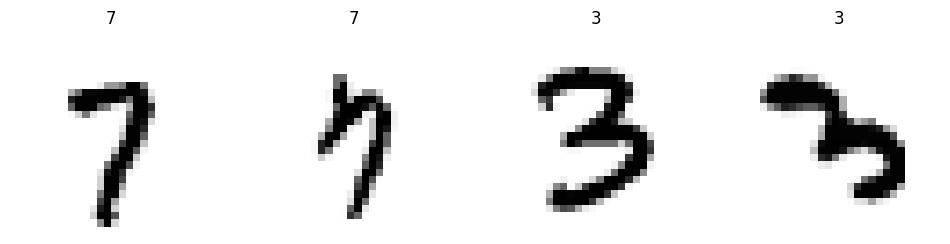

In [6]:
dls.train.show_batch(max_n=4, nrows=1)

In [7]:
# Überprüfen, dass jetzt 1 Kanal reinkommt
xb, yb = dls.one_batch()
print(xb.shape)  # sollte torch.Size([64,1,28,28]) sein

torch.Size([64, 1, 28, 28])


In [ ]:
import torch

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.298190,0.180854,0.055937,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.060926,0.029408,0.009323,00:10
1,0.027779,0.017167,0.005888,00:08
2,0.009530,0.020409,0.006379,00:07
3,0.006620,0.016654,0.003435,00:07


In [ ]:

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()



class SimpleNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 1) Flatten als Attribut hinzufügen
        self.flatten = nn.Flatten()
        self.layer1  = nn.Linear(28*28, 30)
        self.relu    = nn.ReLU()
        self.layer2  = nn.Linear(30, 1)

    def forward(self, x):
        # 2) Erst flatten, dann die linearen Layers
        x = self.flatten(x)     # (bs, 1, 28, 28) → (bs, 784)
        x = self.layer1(x)      # (bs, 784) → (bs, 30)
        x = self.relu(x)
        x = self.layer2(x)      # (bs, 30)  → (bs, 1)
        return x
    

    
simple_net = SimpleNet()

learn = Learner(
    dls,                          # die Daten
    simple_net,                   # das Modell
    opt_func=SGD,                 # Optimierer: Stochastic Gradient Descent
    loss_func=mnist_loss,        # Loss-Funktion
    metrics=error_rate      # Metrik zur Bewertung
)


learn.fit(5, 0.1)  # 40 Epochen, Lernrate 0.1


plt.plot(L(learn.recorder.values).itemgot(2))
plt.xlabel("Epoch")
plt.ylabel("Genauigkeit")
plt.title("Trainingsgenauigkeit über die Zeit")
plt.grid(True)
plt.show()



final_accuracy = learn.recorder.values[-1][2]
print(f"Finale Genauigkeit: {final_accuracy:.4f}")


epoch,train_loss,valid_loss,error_rate,time


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2352 and 784x30)